## CS4243, Week 13 Example
### 2022, Amir

#### This is similar with what we've used for CW4, but we try different aspects of deep learning for image classification
<br> 1- set the base model parameters to image size = 256x256, epochs=100 , dropout=0.5
<br> 2- train and test the model. see the performance, training, validation, and testing accuracy
<br> 3- go to "make_model" function cell
<br> 4- change all the 'relu' activation function to 'sigmoid' , 5 activation functions should be modified. 
<br> 5- run the program, train and test it and see the performances. better? same? worse?
<br> 6- bring the activation functions back to the 'relu'
<br> 7- at the end of "make_model" function, find this lines and make that line a comment: 
<br>  <p style="font-family:arial">
    x = layers.Dropout(0.5)(x)
<br>    x = layers.Dense(25, activation='relu')(x)
<br>    outputs = layers.Dense(units, activation=activation)(x)
<br>    return keras.Model(inputs, outputs)
</p>
<br> chanege to <p style="font-family:arial"> 
<br>    x = layers.Dropout(0.5)(x)
<br>    # x = layers.Dense(25, activation='relu')(x)
<br>    outputs = layers.Dense(units, activation=activation)(x)
<br>    return keras.Model(inputs, outputs)
</p>
<br><br> it means that we are going to have just 1 output neuron and no fully-connected classification layer 
<br> 8- run the model and see the performance. Compared to the base model, is it better? same? worse?

#### To get sure, you can run each model twice

<br> 9- bring back all the modifications 
<br> 10- at "make_model" function, find this lines and make that line a comment: 
<br>  <p style="font-family:arial">
<br>   previous_block_activation = x  # Set aside residual
<br>    for size in [128, 256, 512, 728]:
<br>        x = layers.Activation("relu")(x)
<br>        x = layers.SeparableConv2D(size, 3, padding="same")(x)
<br>        x = layers.BatchNormalization()(x)
</p>
<br> change to <p style="font-family:arial"> 
<br>   previous_block_activation = x  # Set aside residual
<br>    for size in [128, 256, 512, 728]:
<br>        #x = layers.Activation("relu")(x)
<br>        #x = layers.SeparableConv2D(size, 3, padding="same")(x)
<br>        #x = layers.BatchNormalization()(x)
</p>
<br><br> it means that we are going to remove one of the convolution modules
<br> 11- run the model and see the performance. Compared to the base model, is it better? same? worse?

In [1]:
''' 
To run this code on co lab: 

add: import os

add: 
from google.colab import drive
drive.mount('/content/gdrive')
!ls

set the directory, e.g.:
"/content/gdrive/MyDrive/ANN/pets_very_small"
"/content/gdrive/MyDrive/ANN/flst.txt"

flst.txt file should be modified too

'''

' \nTo run this code on co lab: \n\nadd: import os\n\nadd: \nfrom google.colab import drive\ndrive.mount(\'/content/gdrive\')\n!ls\n\nset the directory, e.g.:\n"/content/gdrive/MyDrive/ANN/pets_very_small"\n"/content/gdrive/MyDrive/ANN/flst.txt"\n\nflst.txt file should be modified too\n\n'

In [2]:
# we just need these packages

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [4]:
# to check if we have got GPU or not

In [5]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [6]:
# setting the train and evaluation dataset and directories
# train/evaluation directory is pets_very_small 
#

In [7]:
image_size = (256,256)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "pets_very_small",
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "pets_very_small",
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1042 files belonging to 2 classes.
Using 834 files for training.
Found 1042 files belonging to 2 classes.
Using 208 files for validation.


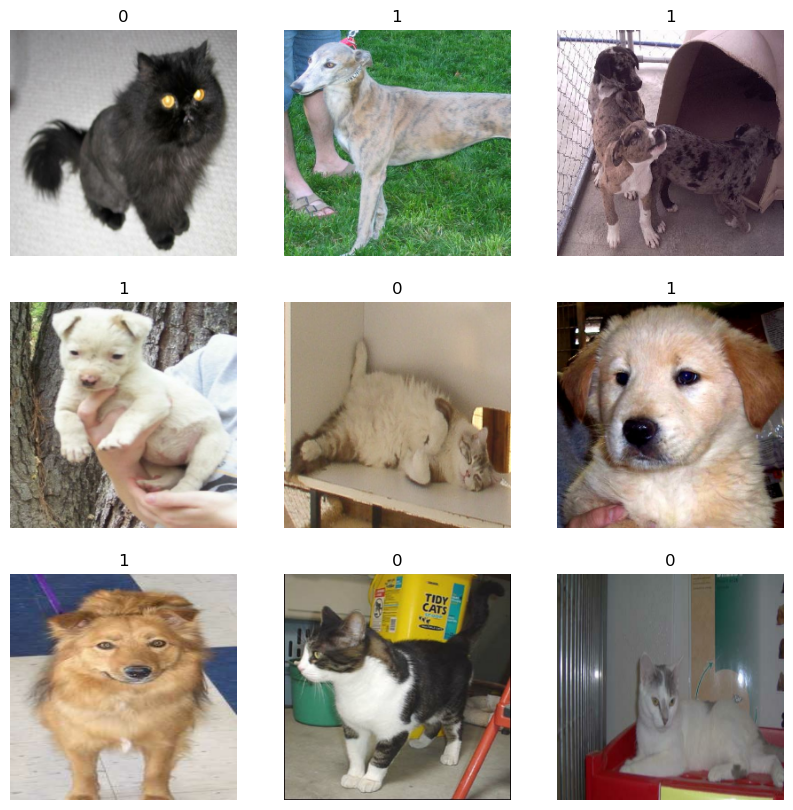

In [8]:
# showing the images 
# 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off") 

In [9]:
# data augmentation, using horizontal flip, and random rotation 
# rotation factor is between 0 to 0.1*2pi 
# 
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

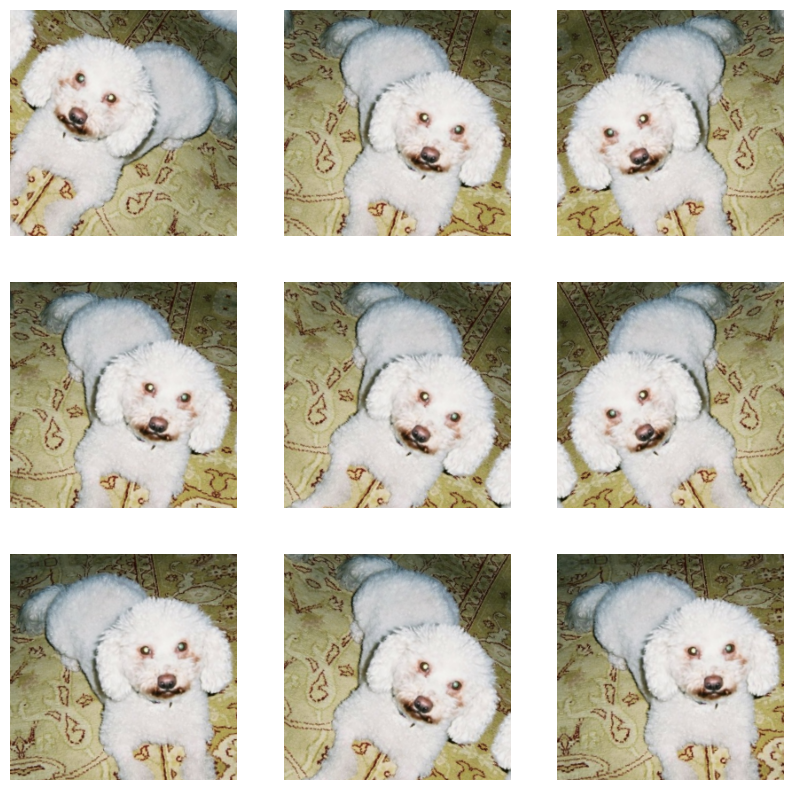

In [10]:
# showing the rotated and flipped images that were added to the 
# original dataset
#
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
# setting train and validation datasets via augmentation

In [12]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [13]:
train_ds = train_ds.prefetch(buffer_size=16)
val_ds = val_ds.prefetch(buffer_size=16)

In [14]:
# making our deep model: make_model function
# basically, it is a deep convolutional netwrok. Structure is very similar with VGG16 and 19
#

In [15]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
   
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(25, activation='relu')(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [16]:
model = make_model(input_shape=image_size + (3,) )


In [17]:
# compiling and training our model

In [18]:
epochs = 100

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [19]:
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'model/batch_normalization_1/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\amir.m\AppData\Local\Temp\ipykernel_28100\1541484022.py", line 1, in <module>
      model.fit(
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\amir.m\.conda\envs\cs4243\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 571, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/batch_normalization_1/FusedBatchNormV3'
OOM when allocating tensor with shape[16,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/batch_normalization_1/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12933]

In [ ]:
# above: the last validation accuracy above, is a good metric 
# to show your classifier performance 
# below: testing the classifier with some images  

In [ ]:
flst = np.loadtxt('flst.txt', dtype=np.character) 
ddmm = len(flst)
tags = np.zeros( (1,ddmm) )
tags[:,27:ddmm]= 1
tags = np.int8( tags.T )

In [ ]:
predct = []
for i in flst:
    img = keras.preprocessing.image.load_img( i , target_size=image_size )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    score = predictions[0]
    print( i , 
        " is %.2f percent cat and %.2f percent dog."
        % (100 * (1 - score), 100 * score)
    )
    predct.append( np.round(score) )


In [ ]:
predct = np.int8( np.array(predct) )
sscc = np.sum(abs(tags-predct))
print('Number of correct classification =' , ddmm-sscc , ' out of ', ddmm , ' means ', round((ddmm-sscc)/ddmm,3) )

In [ ]:
#model.save('resul_saved1')